In [1]:
import matplotlib.pyplot as plt
import time
import pickle
import scipy.stats
from scipy import interpolate
from copy import copy
import pandas as pd

In [2]:
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib
import itertools

In [3]:
from numba import jit, int64, float64,njit

In [423]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [573]:
# %%writefile GTN.py
import numpy as np
import numpy.linalg as nla
import scipy.linalg as la
from copy import copy

class GTN:
    def __init__(self,L,history=True,seed=None,op=False):
        self.L=L
        self.op=op
        self.C_m=self.correlation_matrix(op=op)
        self.C_m_history=[self.C_m]
        self.history=history
        self.rng=np.random.default_rng(seed)
    
    def correlation_matrix(self,op):
        if op:
            return np.zeros((0,0))
        else:
            Omega=np.array([[0,1.],[-1.,0]])
            return np.kron(np.eye(self.L),Omega)

    def measure(self,n_list,ix):
        ''' Majorana site index for ix'''
        if not hasattr(self,'n_history'):
            self.n_history=[]
        if not hasattr(self,'i_history'):
            self.i_history=[]

        m=self.C_m_history[-1].copy()
        proj=[self.kraus(n) for n in n_list]
        ix_bar=np.array([i for i in np.arange(self.L*2) if i not in ix]) if not self.op else np.array([i for i in np.arange(self.L*4) if i not in ix])
        Psi=_contraction(m,proj,ix,ix_bar)
        assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        if self.history:
            self.C_m_history.append(Psi)
            self.n_history.append(n_list)
            self.i_history.append(ix)
        else:
            self.C_m_history=[Psi]
            self.n_history=[n_list]
            self.i_history=[ix]


    def projection(self,s):
        '''
        occupancy number: s= 0,1 
        (-1)^0 even parity, (-1)^1 odd parity

        '''
        assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
        blkmat=np.array([[0,-(-1)**s,0,0],
                        [(-1)**s,0,0,0],
                        [0,0,0,(-1)**s],
                        [0,0,-(-1)**s,0]])
        return blkmat

    def kraus(self,n):
        n[1]=-n[1]
        return -np.array([[0,n[0],n[1],n[2]],
                        [-n[0],0,-n[2],n[1]],
                        [-n[1],n[2],0,-n[0]],
                        [-n[2],-n[1],n[0],0]])
    
    def mutual_information_m(self,subregion_A,subregion_B):
        ''' Composite fermion site index'''
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        s_A=self.von_Neumann_entropy_m(subregion_A)
        s_B=self.von_Neumann_entropy_m(subregion_B)
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def von_Neumann_entropy_m(self,subregion):
        c_A=self.c_subregion_m(subregion)
        val=nla.eigvalsh(1j*c_A)
        self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2+1e-18j   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def c_subregion_m(self,subregion,Gamma=None):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_f()
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregion=linearize_index(subregion,2)
        return Gamma[np.ix_(subregion,subregion)]

    def measure_all(self,a1,a2,b1,b2,even=True,theta_list=0,phi_list=0,Born=False):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        if Born:
            Gamma_list=self.C_m_history[-1][proj_range,(proj_range+1)%(2*self.L)]
            n_list=get_Born(a1,a2,b1,b2,Gamma_list,theta_list=theta_list,phi_list=phi_list,rng=self.rng)
        else:
            n_list=get_random(a1,a2,b1,b2,proj_range.shape[0],theta_list=theta_list,phi_list=phi_list,rng=self.rng)
        for i,n in zip(proj_range,n_list):
            self.measure([n], np.array([i,(i+1)%(2*self.L)]))

    def measure_all_sync(self,a1,a2,b1,b2,even=True,theta_list=0,phi_list=0,Born=False):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        C_m=self.C_m_history[-1]
        proj_range_1=proj_range if not self.op else proj_range+2* self.L
        proj_range_2=(proj_range+1)%(2*self.L) if not self.op else (proj_range+1)%(2*self.L) + 2*self.L
        if isinstance(theta_list, int) or isinstance(theta_list, float):
            theta_list=[theta_list]*len(proj_range_1)
        if isinstance(phi_list, int) or isinstance(phi_list, float):
            phi_list=[phi_list]*len(proj_range_1)
        if Born:
            if C_m.size==0:
                Gamma_list=np.array([1]*self.L)
                n_list=get_Born(a1,a2,b1,b2,Gamma_list,theta_list=theta_list,phi_list=phi_list,rng=self.rng)
                self.measure(n_list,np.c_[proj_range_1,proj_range_2].flatten())
            else:
                for i,j,theta,phi in zip(proj_range_1,proj_range_2,theta_list,phi_list):
                    Gamma=C_m[[i],[j]]
                    n_list=get_Born(a1,a2,b1,b2,Gamma,theta_list=theta,phi_list=phi,rng=self.rng)
                    self.measure(n_list,[i,j])
        else:
            n_list=get_random(a1,a2,b1,b2,proj_range.shape[0],theta_list=theta_list,phi_list=phi_list,rng=self.rng)
            self.measure(n_list,np.c_[proj_range_1,proj_range_2].flatten())
    def measure_all_Haar(self,sigma=0,even=True,theta_list=0,phi_list=0):
        proj_range=np.arange(self.L)*2 if even else np.arange(self.L)*2+1
        C_m=self.C_m_history[-1]
        proj_range_1=proj_range
        proj_range_2=(proj_range+1)%(2*self.L)
        if isinstance(theta_list, int) or isinstance(theta_list, float):
            theta_list=[theta_list]*len(proj_range_1)
        if isinstance(phi_list, int) or isinstance(phi_list, float):
            phi_list=[phi_list]*len(proj_range_1)
        n_list=get_Haar(sigma,proj_range.shape[0],rng=self.rng,theta_list=theta_list,phi_list=phi_list)
        self.measure(n_list,np.c_[proj_range_1,proj_range_2].flatten())


    def mutual_information_cross_ratio(self):
        x=np.array([0,self.L//4,self.L//2,self.L//4*3])
        # x=np.array([0,self.L//8,self.L//2,self.L//8*5])
        MI=[]
        subA=np.arange(x[0],x[1])
        subB=np.arange(x[2],x[3])
        for shift in range(self.L//2):
            MI.append(self.mutual_information_m((subA+shift)%self.L, (subB+shift)%self.L))
        return np.mean(MI)

    def entanglement_contour(self,subregion):
        c_A=self.c_subregion_m(subregion)
        C_f=(np.eye(c_A.shape[0])+1j*c_A)/2
        f,_=la.funm(C_f,lambda x: -x*np.log(x),disp=False)
        return np.diag(f).real.reshape((-1,2)).sum(axis=1).real


def get_random(a1,a2,b1,b2,num,rng=None,theta_list=0,phi_list=0):
    '''
        -b1<-a1<a2<b2 
        
        n1=True: nA=(n1,n2,n3)
        n1=True: nB=(n3,n1,n2)
    '''
    assert -b1<=-a1<=a2<=b2, "the order of -b1<-a1<a2<b2 not satisfied"
    rng=np.random.default_rng(rng)
    sign=rng.random(size=num)
    # inverse of CDF
    n1=np.where(sign<.5,sign*2*(b1-a1)-b1,(sign-1/2)*2*(b2-a2)+a2)

    # use rescale
    # n1=np.where(sign<0.5,rescale(sign,y0=-b1,y1=-a1,x0=0,x1=.5),rescale(sign,y0=a2,y1=b2,x0=.5,x1=1))
    # complete random
    # n1=np.random.uniform(b2,b1-a1+a2,num)
    # n1=np.where(n1<a2,n1,n1+(a1-a2))

    n2,n3=get_inplane(n1, num,rng=rng)
    n=np.c_[n1,n2,n3]
    return rotate(n,theta_list,phi_list)

def rotate(n,theta,phi):
    n=np.c_[np.cos(theta)*n[:,0]-np.sin(theta)*n[:,1],np.sin(theta)*n[:,0]+np.cos(theta)*n[:,1],n[:,2]]
    n=np.c_[np.cos(phi)*n[:,0]+np.sin(phi)*n[:,2],n[:,1],-np.sin(phi)*n[:,0]+np.cos(phi)*n[:,2]]
    return n


def get_inplane(n1,num,rng=None,sigma=1):
    r=np.sqrt(1-n1**2)
    rng=np.random.default_rng(rng)
    phi=rng.random(num)*2*np.pi*sigma
    n2,n3=r*np.cos(phi),r*np.sin(phi)
    return n2,n3

def get_Born(a1,a2,b1,b2,Gamma,rng=None,theta_list=0,phi_list=0):
    '''
        -b1<-a1<a2<b2 
        Gamma: list for all parities
        
        n1=True: nA=(n1,n2,n3)
        n1=True: nB=(n3,n1,n2)
    '''
    assert -b1<=-a1<=a2<=b2, "the order of -b1<-a1<a2<b2 not satisfied"
    num=Gamma.shape[0]
    rng=np.random.default_rng(rng)
    u=rng.random(size=num)
    theta1,theta2=(a2+b2)/((b1-a1)*(a1+a2+b1+b2)),(a1+b1)/((b2-a2)*(a1+a2+b1+b2))
    bndy=theta1*(-a1+b1+1/2*(a1**2-b1**2)*Gamma)
    coef1=1/2*theta1*Gamma,theta1,theta1*b1-1/2*theta1*b1**2*Gamma
    coef2=1/2*theta2*Gamma,theta2,theta1*(-a1+b1+(a1**2-b1**2)*Gamma/2)-a2**2*Gamma*theta2/2-theta2*a2

    n1=np.where(u<bndy,solve(coef1,u),solve(coef2,u))

    n2,n3=get_inplane(n1, num,rng=rng)
    n=np.c_[n1,n2,n3]
    return rotate(n,theta_list,phi_list)

def get_Haar(sigma,num,rng=None,theta_list=0,phi_list=0):
    rng=np.random.default_rng(rng)
    u=rng.random(size=num)
    n1=rescale(u, 1-2*sigma, 1)
    n2,n3=get_inplane(n1, num,rng=rng)
    n=np.c_[n1,n2,n3]
    return rotate(n,theta_list,phi_list)

def solve(coef,u):
    a,b,c=coef
    c=c-u
    with np.errstate(invalid='ignore'):
        n1=np.where(a==0,-c/b,(-b+np.sqrt(b**2-4*a*c))/(2*a) )
    return n1


def rescale(x,y0,y1,x0=0,x1=1):
    return (y1-y0)/(x1-x0)*(x-x0)+y0

def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta

def cord(x,L):
    return L/np.pi*np.sin(np.pi/L*np.abs(x))

# @jit(float64[:,:](float64[:,:],float64[:,:],int64[:]),nopython=True,fastmath=True)
def _contraction(m,proj_list,ix,ix_bar):
    ix,ix_bar=list(ix),list(ix_bar)

    proj=np.zeros((4*len(proj_list),4*len(proj_list)))
    # change index from (in_1, in_2, out_1, out_2) (in_3, in_4, out_3, out_4)
    # to (in_1 , in_2, in_3, in_4, out_1, out_2, out_3, out_4)
    for i,p in enumerate(proj_list):
        proj[np.ix_([2*i,2*i+1,2*i+2*len(proj_list),2*i+2*len(proj_list)+1],[2*i,2*i+1,2*i+2*len(proj_list),2*i+2*len(proj_list)+1])]=p

    if m.size==0:
        return proj
    else:
        Gamma_LL=m[np.ix_(ix_bar,ix_bar)]
        Gamma_LR=m[np.ix_(ix_bar,ix)]
        Gamma_RR=m[np.ix_(ix,ix)]

    Upsilon_LL=proj[:len(ix),:len(ix)]
    Upsilon_RR=proj[len(ix):,len(ix):]
    Upsilon_RL=proj[len(ix):,:len(ix)]

    mat1,mat2,mat3=np.zeros(m.shape),np.zeros((m.shape[0],2*len(ix))),np.zeros((2*len(ix),2*len(ix)))
    mat1[:-len(ix),:-len(ix)]=Gamma_LL
    mat1[-len(ix):,-len(ix):]=Upsilon_RR
    mat2[:-len(ix),:len(ix)]=Gamma_LR
    mat2[-len(ix):,-len(ix):]=Upsilon_RL
    mat3[:len(ix),:len(ix)]=Gamma_RR
    mat3[len(ix):,len(ix):]=Upsilon_LL
    mat3[:len(ix),len(ix):]=np.eye(len(ix))
    mat3[len(ix):,:len(ix)]=-np.eye(len(ix))

    if np.count_nonzero(mat2):
        Psi=mat1+mat2@(nla.solve(mat3,mat2.T))
        # Psi=mat1+mat2@nla.inv(mat3)@mat2.T
        # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
    else:
        print('mat2 is singular')
        Psi=mat1
    
    Psi_mat=np.zeros_like(Psi)
    Psi_mat[np.ix_(ix_bar,ix_bar)]=Psi[:len(ix_bar),:len(ix_bar)]
    Psi_mat[np.ix_(ix,ix)]=Psi[-len(ix):,-len(ix):]
    Psi_mat[np.ix_(ix_bar,ix)]=Psi[:len(ix_bar),-len(ix):]
    Psi_mat[np.ix_(ix,ix_bar)]=Psi[-len(ix):,:len(ix_bar)]
    Psi=Psi_mat

    Psi=(Psi-Psi.T)/2
    return Psi

def linearize_index(subregion,n,k=2,proj=False):
    try:
        subregion=np.array(subregion)
    except:
        raise ValueError("The subregion is ill-defined"+subregion)
    if proj:
        return sorted(np.concatenate([n*subregion+i for i in range(0,n,k)]))
    else:
        return sorted(np.concatenate([n*subregion+i for i in range(n)]))
    
def interpolate(x1,x2,l0,h0,L,k=1):
    x=np.arange(L)
    h=h0/2
    l=l0-h0/2
    return (h-l)/2*(np.tanh((x-x1)*k)+1)+l-(h-l)/2*(np.tanh((x-x2)*k)+1)+h

In [412]:
gtn=GTN(L=4,seed=2,op=False)
# gtn.measure([[0,np.sqrt(1/2),np.sqrt(1/2)],[0,0.1,np.sqrt(1-0.1**2)]],np.array([1,2,3,4]))
gtn.measure_all_sync(0, 0, 1, 1,even=False)
gtn.measure_all_sync(0, 0, 1, 1,even=True)

In [410]:
gtn2=GTN(L=4,seed=2,op=False)
# gtn2.measure([[0,np.sqrt(1/2),-np.sqrt(1/2)],[0,-0.1,np.sqrt(1-0.1**2)]],np.array([1,2,3,4]))
gtn2.measure_all_sync(0, 0, 1, 1,even=False)
gtn2.measure_all_sync(0, 0, 1, 1,even=True)

In [413]:
gtn.von_Neumann_entropy_m(range(gtn.L//2))

0.845082507932084

In [414]:
gtn2.von_Neumann_entropy_m(range(gtn.L//2))

0.8450825079320842

In [415]:
np.round(gtn.C_m_history[-1],2)

array([[ 0.  , -0.52, -0.19, -0.66, -0.2 , -0.11,  0.41,  0.2 ],
       [ 0.52,  0.  , -0.03,  0.33, -0.01, -0.64,  0.11,  0.45],
       [ 0.19,  0.03,  0.  ,  0.14, -0.85, -0.07,  0.05, -0.46],
       [ 0.66, -0.33, -0.14,  0.  ,  0.39,  0.18,  0.01, -0.51],
       [ 0.2 ,  0.01,  0.85, -0.39,  0.  , -0.14, -0.24, -0.04],
       [ 0.11,  0.64,  0.07, -0.18,  0.14,  0.  ,  0.7 , -0.16],
       [-0.41, -0.11, -0.05, -0.01,  0.24, -0.7 ,  0.  , -0.52],
       [-0.2 , -0.45,  0.46,  0.51,  0.04,  0.16,  0.52,  0.  ]])

In [416]:
np.round(gtn2.C_m_history[-1],2)

array([[ 0.  , -0.52,  0.19, -0.66,  0.2 , -0.11, -0.41,  0.2 ],
       [ 0.52,  0.  , -0.03, -0.33, -0.01,  0.64,  0.11, -0.45],
       [-0.19,  0.03,  0.  ,  0.14,  0.85, -0.07, -0.05, -0.46],
       [ 0.66,  0.33, -0.14,  0.  ,  0.39, -0.18,  0.01,  0.51],
       [-0.2 ,  0.01, -0.85, -0.39,  0.  , -0.14,  0.24, -0.04],
       [ 0.11, -0.64,  0.07,  0.18,  0.14,  0.  ,  0.7 ,  0.16],
       [ 0.41, -0.11,  0.05, -0.01, -0.24, -0.7 ,  0.  , -0.52],
       [-0.2 ,  0.45,  0.46, -0.51,  0.04, -0.16,  0.52,  0.  ]])

In [363]:
gtn.C_m_history[-1]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0., -0.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [-0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [165]:
gtn.measure([[0,1/np.sqrt(2),1/np.sqrt(2)]],np.array([0,1]))

In [275]:
gtn.measure([[0,1/np.sqrt(2),1/np.sqrt(2)]],np.array([3,0]))

In [364]:
# gtn.measure([[0.9,np.sqrt(1-0.9**2),0]],np.array([1,2]))
gtn.measure([[0,np.sqrt(1/2),np.sqrt(1/2)]]*3,np.array([1,2,3,4,5,0]))
# gtn.measure([[0.9,np.sqrt(1-0.9**2),0]],np.array([3,4]))

In [335]:
neg=np.round(gtn.C_m_history[-1],3)

In [338]:
pos=np.round(gtn.C_m_history[-1],3)

In [339]:
neg,pos

(array([[ 0. ,  0.5,  0.5,  0.5,  0.5,  0. ],
        [-0.5,  0. ,  0. ,  0.5, -0.5,  0.5],
        [-0.5,  0. ,  0. , -0.5,  0.5,  0.5],
        [-0.5, -0.5,  0.5,  0. ,  0. , -0.5],
        [-0.5,  0.5, -0.5,  0. ,  0. , -0.5],
        [ 0. , -0.5, -0.5,  0.5,  0.5,  0. ]]),
 array([[ 0. ,  0.5, -0.5,  0.5, -0.5,  0. ],
        [-0.5,  0. ,  0. , -0.5, -0.5, -0.5],
        [ 0.5,  0. ,  0. , -0.5, -0.5,  0.5],
        [-0.5,  0.5,  0.5,  0. ,  0. ,  0.5],
        [ 0.5,  0.5,  0.5,  0. ,  0. , -0.5],
        [ 0. ,  0.5, -0.5, -0.5,  0.5,  0. ]]))

In [251]:
gtn.C_m_history[-1]

array([[ 0.        ,  0.        ,  0.43588989,  0.9       ],
       [ 0.        ,  0.        ,  0.9       , -0.43588989],
       [-0.43588989, -0.9       ,  0.        ,  0.        ],
       [-0.9       ,  0.43588989,  0.        ,  0.        ]])

In [ ]:
gtn.C_m_history[-1]

array([[ 0.        , -0.1       , -0.99498744,  0.        ],
       [ 0.1       ,  0.        ,  0.        ,  0.99498744],
       [ 0.99498744,  0.        ,  0.        , -0.1       ],
       [ 0.        , -0.99498744,  0.1       ,  0.        ]])

In [72]:
gtn.measure_all_sync(a1=.5, a2=.9, b1=1, b2=1,even=True,theta_list=0,phi_list=0,Born=True)

In [77]:
np.round(gtn.C_m_history[-1],3)

array([[-0.   , -0.914,  0.   ,  0.   , -0.159,  0.372,  0.   ,  0.   ],
       [ 0.914, -0.   ,  0.   ,  0.   , -0.372, -0.159,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.   , -0.919,  0.   ,  0.   , -0.331, -0.215],
       [ 0.   ,  0.   ,  0.919, -0.   ,  0.   ,  0.   ,  0.215, -0.331],
       [ 0.159,  0.372,  0.   ,  0.   , -0.   ,  0.914,  0.   ,  0.   ],
       [-0.372,  0.159,  0.   ,  0.   , -0.914, -0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.331, -0.215,  0.   ,  0.   , -0.   ,  0.919],
       [ 0.   ,  0.   ,  0.215,  0.331,  0.   ,  0.   , -0.919, -0.   ]])

In [78]:
gtn.von_Neumann_entropy_m(np.arange(gtn.L))

0.3463744671333685

In [79]:
vk=gtn.n_history[0][:,0]

In [82]:
np.sum(-(1-vk)/2*np.log((1-vk)/2)-(1+vk)/2*np.log((1+vk)/2))

0.3463744671333685

In [563]:
gtn.measure_all_sync(a1=.5, a2=.9, b1=1, b2=1,even=True,theta_list=0,phi_list=0,Born=True)
gtn.measure_all_sync(a1=.5, a2=.9, b1=1, b2=1,even=False,theta_list=np.pi/2,phi_list=np.pi/2,Born=True)

In [ ]:
np.round(gtn.C_m_history[-1],3)

array([[ 0.   ,  0.238, -0.239, -0.364, -0.266,  0.166, -0.755,  0.293],
       [-0.238,  0.   , -0.762,  0.401, -0.016, -0.069, -0.126, -0.425],
       [ 0.239,  0.762,  0.   ,  0.488,  0.057, -0.112,  0.083,  0.317],
       [ 0.364, -0.401, -0.488,  0.   ,  0.269,  0.03 ,  0.175,  0.604],
       [ 0.266,  0.016, -0.057, -0.269,  0.   , -0.911, -0.095, -0.123],
       [-0.166,  0.069,  0.112, -0.03 ,  0.911,  0.   , -0.347, -0.068],
       [ 0.755,  0.126, -0.083, -0.175,  0.095,  0.347,  0.   , -0.498],
       [-0.293,  0.425, -0.317, -0.604,  0.123,  0.068,  0.498,  0.   ]])

In [550]:
gtn.measure([[1/np.sqrt(2),-1/np.sqrt(2),0]], [2,3])
gtn.measure([[1/np.sqrt(2),1/np.sqrt(2),0]], [0,1])

In [546]:
np.round(gtn.C_m_history[-1],3)

array([[ 0.   ,  0.873,  0.068,  0.104,  0.156, -0.076,  0.412, -0.15 ],
       [-0.873,  0.   ,  0.217, -0.114,  0.073,  0.031,  0.116,  0.397],
       [-0.068, -0.217,  0.   ,  0.944,  0.083, -0.093,  0.194,  0.057],
       [-0.104,  0.114, -0.944,  0.   ,  0.094,  0.026, -0.017,  0.273],
       [-0.156, -0.073, -0.083, -0.094,  0.   , -0.947, -0.066, -0.232],
       [ 0.076, -0.031,  0.093, -0.026,  0.947,  0.   , -0.295,  0.02 ],
       [-0.412, -0.116, -0.194,  0.017,  0.066,  0.295,  0.   , -0.829],
       [ 0.15 , -0.397, -0.057, -0.273,  0.232, -0.02 ,  0.829,  0.   ]])

In [551]:
np.round(gtn.C_m_history[-1],3)

array([[ 0.   ,  0.873,  0.068,  0.104,  0.156, -0.076,  0.412, -0.15 ],
       [-0.873,  0.   ,  0.217, -0.114,  0.073,  0.031,  0.116,  0.397],
       [-0.068, -0.217,  0.   ,  0.944,  0.083, -0.093,  0.194,  0.057],
       [-0.104,  0.114, -0.944,  0.   ,  0.094,  0.026, -0.017,  0.273],
       [-0.156, -0.073, -0.083, -0.094,  0.   , -0.947, -0.066, -0.232],
       [ 0.076, -0.031,  0.093, -0.026,  0.947,  0.   , -0.295,  0.02 ],
       [-0.412, -0.116, -0.194,  0.017,  0.066,  0.295,  0.   , -0.829],
       [ 0.15 , -0.397, -0.057, -0.273,  0.232, -0.02 ,  0.829,  0.   ]])

In [488]:
gtn.von_Neumann_entropy_m(np.arange(gtn.L)+gtn.L)

0.7680219731036124

In [679]:
odd=interpolate(32, 96, np.pi/2, 0, 128,k=1)
even=interpolate(32, 96, 0,np.pi/2, 128,k=1)

Text(0, 0.5, 'rotation along n3 [pi]')

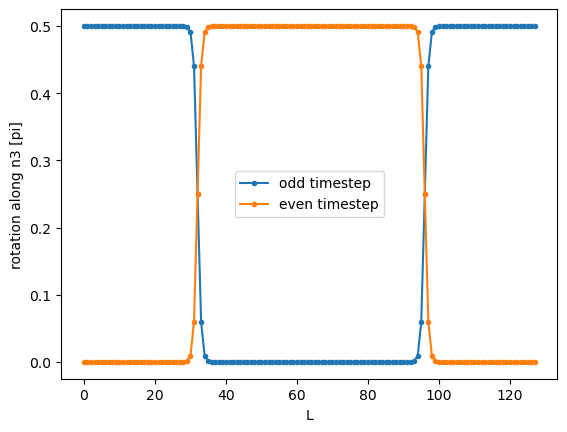

In [684]:
plt.plot(odd/(np.pi),'.-',label='odd timestep')
plt.plot(even/(np.pi),'.-',label='even timestep')
plt.legend()
plt.xlabel('L')
plt.ylabel('rotation along n3 [pi]')

In [475]:
np.round(rotate(np.array([[1,0,0]]*3), [0,np.pi/4,np.pi/2],[np.pi/2]*3),3)

array([[0.   , 0.   , 1.   ],
       [0.   , 0.707, 0.707],
       [0.   , 1.   , 0.   ]])

In [125]:
zz=np.arange(36).reshape((6,6))

In [85]:
zz

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [187]:
swap(zz,[1,2])

In [186]:
zz

array([[ 0,  4,  5,  3,  1,  2],
       [24, 28, 29, 27, 25, 26],
       [30, 34, 35, 33, 31, 32],
       [18, 22, 23, 21, 19, 20],
       [ 6, 10, 11,  9,  7,  8],
       [12, 16, 17, 15, 13, 14]])

In [188]:
zz

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [89]:
zz[np.ix_([1,2],[1,2])]

array([[ 7,  8],
       [13, 14]])

In [20]:
# zz=get_Born(b2=.3,a2=.2, a1=.5,b1= 1,Gamma=np.linspace(-1,1,1000))
z0=get_random(b2=.3,a2=.2, a1=.5,b1= 1,rng=0,num=1,theta_list=0,phi_list=0)
z1=get_random(b2=.3,a2=.2, a1=.5,b1= 1,rng=0,num=1,theta_list=np.pi/2,phi_list=np.pi/2)

In [21]:
z0

array([[ 0.22739234, -0.12075508,  0.96628719]])

In [22]:
z1

array([[ 0.96628719,  0.22739234, -0.12075508]])

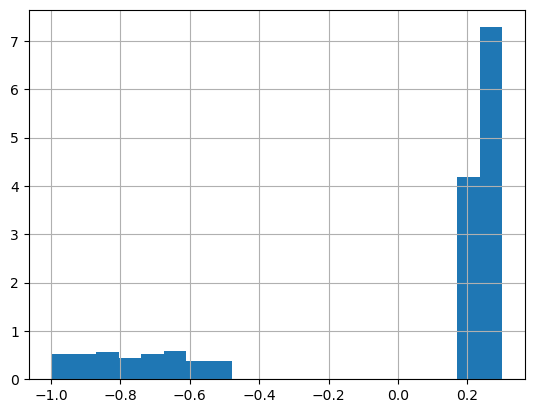

In [119]:
fig,ax=plt.subplots()
ax.hist(zz[:,0],bins=20,density=True)
ax.grid('on')

In [517]:
zz=get_random(a1=.6,a2= .6,b1=.8,b2= .8,num= 1000,theta_list=np.pi/4,phi_list=0)

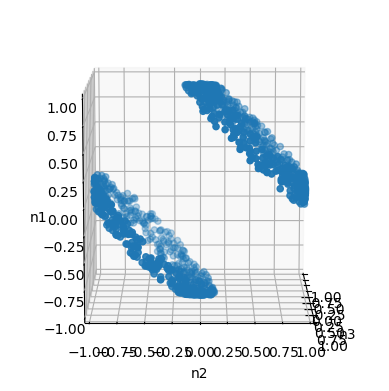

In [518]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# zz=np.array((gtn.n_history)[:64])
ax.scatter(zz[:,2],zz[:,1],zz[:,0])
ax.set_xlabel('n3')
ax.set_ylabel('n2')
ax.set_zlabel('n1')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(azim=0,elev=10)
ax.set_box_aspect([1,1,1])

In [10]:
rr=np.random.default_rng(0)

In [13]:
np.random.default_rng(rr)

Generator(PCG64) at 0x7F35190F36D0

In [12]:
rr

Generator(PCG64) at 0x7F35190F36D0

In [157]:
zz.flatten()

array([ 0,  4,  5,  3,  1,  2, 24, 28, 29, 27, 25, 26, 30, 34, 35, 33, 31,
       32, 18, 22, 23, 21, 19, 20,  6, 10, 11,  9,  7,  8, 12, 16, 17, 15,
       13, 14])

In [259]:
zz=np.arange(8)

In [262]:
zz[[1,2,3,4,5,6,7]]=zz[[5,6,7,1,2,3,4]]

In [263]:
zz

array([0, 2, 3, 4, 5, 6, 7, 1])

In [321]:
gtn=GTN(L=2,seed=2)
gtn.measure([[1,0,0],[1,0,0]], [1,2,3,0])
np.round(gtn.C_m_history[-1],3)

array([[ 0.,  0.,  0., -1.],
       [ 0.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]])

In [347]:
gtn_orig=GTN(L=3,seed=2)
# gtn_orig.measure([[1,0,0]], [1,2])
# gtn_orig.measure([[1,0,0]], [3,4])
gtn_orig.measure([[1,0,0]], [5,0])
# gtn_orig.measure([[1,0,0]], [3,0])
np.round(gtn_orig.C_m_history[-1],3)

array([[ 0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
gtn_orig=GTN(L=4,seed=2)
gtn_orig.measure([[1,0,0]], [3,4])
gtn_orig.measure([[1,0,0]], [1,2])
np.round(gtn_orig.C_m_history[-1],3)

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [284]:
np.array_equal(gtn_orig.C_m_history[-1], gtn.C_m_history[-1])

True

In [184]:
gtn_orig_2=GTN(L=2,seed=2)
gtn_orig_2.measure([[1,0,0]], [3,4])
gtn_orig_2.measure([[1,0,0]], [1,2])
np.round(gtn_orig_2.C_m_history[-1],3)

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [185]:
gtn_orig_2.C_m_history[-1]==gtn_orig.C_m_history[-1]

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [176]:
np.round(gtn.C_m_history[-1],3)

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [482]:
gtn=GTN(L=4,seed=2)

In [480]:
gtn.measure_all(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
gtn.measure_all(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

In [483]:
gtn.measure_all_sync(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
gtn.measure_all_sync(b2=1,a2= 0, a1=0,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

In [484]:
gtn.mutual_information_cross_ratio()

0.2993099195910174

In [481]:
gtn.mutual_information_cross_ratio()

0.2993099195910174

In [ ]:
gtn.mutual_information_cross_ratio()

0.4530013255727704

In [ ]:
gtn.n_history

In [ ]:
gtn.n_history

In [429]:
L=512

In [443]:
def profile():
    gtn=GTN(L=L,seed=1,history=False)
    iteration=range(1)
    for i in iteration:
        gtn.measure_all(b2=1,a2= .9999, a1=.9999,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
        gtn.measure_all(b2=1,a2= .9999, a1=.9999,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

In [441]:
profile()

In [ ]:
%lprun -f _contraction profile()

In [489]:
L=64
iteration=np.arange(100)
MI=np.zeros((iteration.shape[0],))
gtn=GTN(L=L,seed=0)
for i in iteration:
    gtn.measure_all_sync(b2=1,a2= .999, a1=.999,b1= 1,even=True,theta_list=0,phi_list=0)
    gtn.measure_all_sync(b2=1,a2= .999, a1=.999,b1= 1,even=False,theta_list=np.pi/2,phi_list=np.pi/2)
    # MI[i]=(gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2)))
    MI[i]=gtn.mutual_information_cross_ratio()

In [519]:
L=64
iteration=np.arange(100)
MI=np.zeros((iteration.shape[0],))
gtn=GTN(L=L,seed=0)
for i in iteration:
    gtn.measure_all_sync(b2=1,a2= .999, a1=.999,b1= 1,even=True,theta_list=0,phi_list=0)
    gtn.measure_all_sync(b2=1,a2= .999, a1=.999,b1= 1,even=False,theta_list=np.pi/2,phi_list=0)
    # MI[i]=(gtn.mutual_information_m(np.arange(gtn.L//2), gtn.L//2+np.arange(gtn.L//2)))
    MI[i]=gtn.mutual_information_cross_ratio()

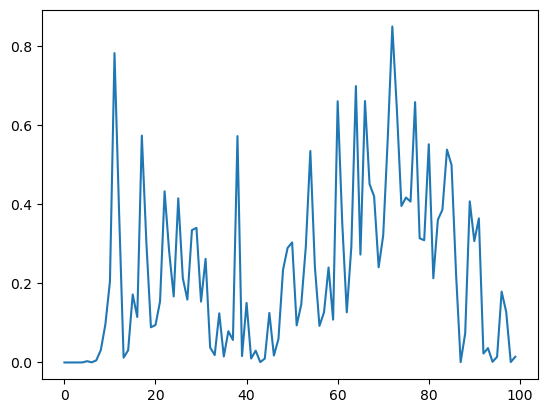

In [520]:
plt.plot(iteration,MI/np.log(2))

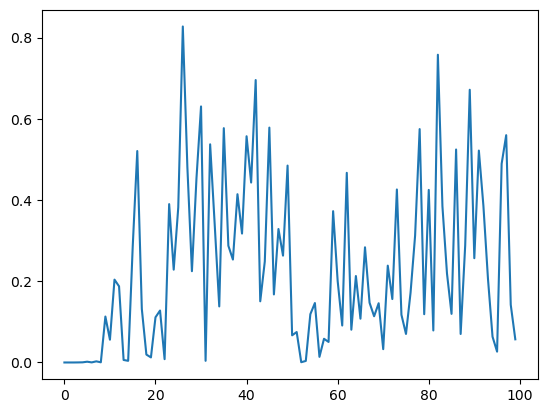

In [351]:
plt.plot(iteration,MI/np.log(2))

In [153]:
gtn=GTN(L=4,seed=1)
gtn.measure_all_sync(b2=1,a2=.999, a1=.999,b1= 1,Born=True,even=True,theta_list=np.pi/2,phi_list=0)

In [154]:
gtn.C_m_history[-1]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
gtn.C_m_history[-1]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [598]:
phi=np.pi/2

In [600]:
isinstance(phi,float)

True

In [465]:
# L=128
L_list=[32,64,128,256]
iteration=np.arange(100)
ensemble_size=20
MI=np.zeros((ensemble_size,iteration.shape[0],))
# EC=np.zeros((ensemble_size,iteration.shape[0],L))
EE=np.zeros((ensemble_size,iteration.shape[0],L//2-1))
SL2=np.zeros((len(L_list),ensemble_size,))
# gtn_list=[]
for L_i,L in enumerate(L_list):
    print(L)
    for ensemble in range(ensemble_size):
        gtn=GTN(L=L,seed=ensemble,history=True,op=False)
        for i in iteration:
            # gtn.measure_all_sync(b2=1,a2=.9, a1=.5,b1= 1,Born=True,even=True,theta_list=interpolate(gtn.L//4, gtn.L//4*3, 0, np.pi/2, gtn.L,k=1),phi_list=0)
            # gtn.measure_all_sync(b2=1,a2=.9, a1=.5,b1= 1,Born=True,even=False,theta_list=interpolate(gtn.L//4, gtn.L//4*3, np.pi/2, 0, gtn.L,k=1),phi_list=0)

            # gtn.measure_all_sync(b2=1,a2=.9, a1=.5,b1= 1,Born=True,even=True,theta_list=0,phi_list=0)
            # gtn.measure_all_sync(b2=1,a2=.9, a1=.5,b1= 1,Born=True,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

            gtn.measure_all_sync(b2=1,a2=0, a1=.0,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
            gtn.measure_all_sync(b2=1,a2=0, a1=.0,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=np.pi/2)

            # gtn.measure_all_sync(b2=1,a2=0.999, a1=0.999,b1= 1,Born=False,even=True,theta_list=0,phi_list=0)
            # gtn.measure_all_sync(b2=1,a2=0.999, a1=0.999,b1= 1,Born=False,even=False,theta_list=np.pi/2,phi_list=0)

            # MI[ensemble,i]=(gtn.mutual_information_m((gtn.L//8*7+np.arange(gtn.L//4))%gtn.L, (gtn.L//8*3+np.arange(gtn.L//4))))
            # MI[ensemble,i]=(gtn.mutual_information_m(gtn.L//8+np.arange(gtn.L//4), gtn.L//8*5+np.arange(gtn.L//4)))
            # MI[ensemble,i]=(gtn.mutual_information_m(gtn.L+gtn.L//8+np.arange(gtn.L//4), gtn.L+gtn.L//8*5+np.arange(gtn.L//4)))
            # EC[ensemble,i]=gtn.entanglement_contour(gtn.L+np.arange(gtn.L))

            # EE[ensemble,i,:]=[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L)/np.log(2) for i in range(gtn.L)]) for dl in range(gtn.L//2-1,gtn.L//2)]

            # MI[ensemble, i]=gtn.mutual_information_cross_ratio()
        SL2[L_i,ensemble]=np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+gtn.L//2))%gtn.L) for i in range(gtn.L)])

32
64
128
256


In [431]:
gtn.mutual_information_cross_ratio()

0.5807633670150797

In [346]:
gtn2.mutual_information_cross_ratio()

0.6127443542186264

In [357]:
gtn.von_Neumann_entropy_m(np.arange(gtn.L//2))

2.463067958103565

In [358]:
gtn2.von_Neumann_entropy_m(np.arange(gtn2.L//2))

2.463067958103565

In [ ]:
(gtn.C_m_history[-1]==gtn2.C_m_history[-1])[:8,:8]

In [ ]:
np.diag(gtn2.C_m_history[-1],k=1)

In [118]:
nla.norm(gtn.n_history[80],axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [226]:
EE=[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L)/np.log(2) for i in range(gtn.L)]) for dl in range(1,gtn.L//2)]

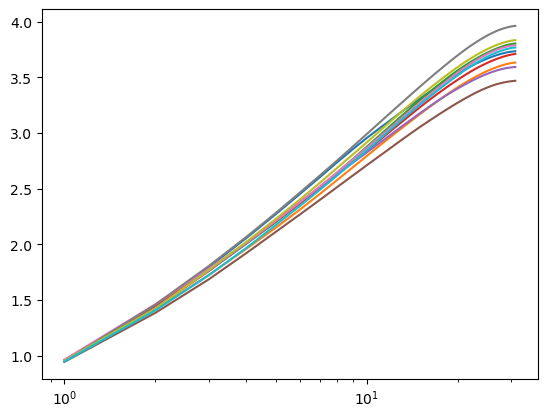

In [418]:
fig,ax=plt.subplots()
# ax.plot(range(1,gtn.L//2),EE)
ax.plot(range(1,gtn.L//2),EE[0,-10:,:].T)
ax.set_xscale('log')
# ax.plot(range(1,gtn.L//2),2*.39*np.log(range(1,gtn.L//2))+.9)

In [88]:
MI.mean(axis=0)[-20:].mean()

0.09098718285045124

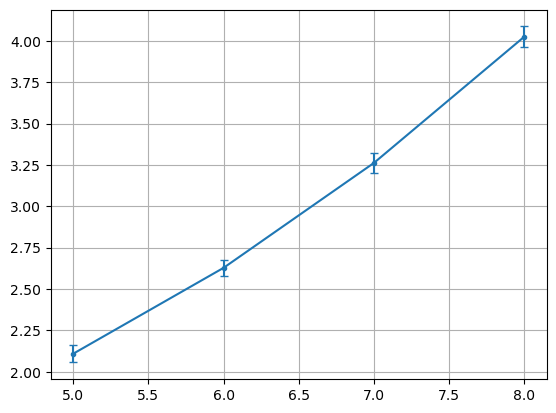

In [468]:
fig,ax=plt.subplots()
ax.errorbar(np.log2(L_list),SL2.mean(axis=1),SL2.std(axis=1)/np.sqrt(SL2.shape[0]),capsize=3,fmt='.-')
# ax.set_xscale('log')
ax.grid('on')

In [473]:
SL2.mean(axis=1)-np.array([1.49,2.13,2.78,3.46])

array([0.61911744, 0.49799907, 0.48188443, 0.56434962])

In [470]:
(SL2[0].mean()-SL2[-1].mean())/(np.log(32)-np.log(256))

0.9210319894661528

Text(0, 0.5, 'MI ')

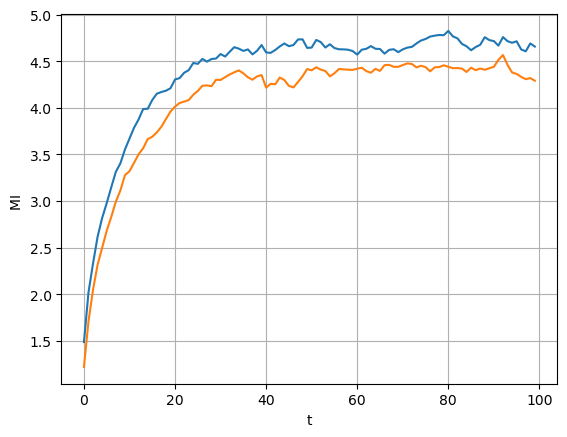

In [448]:
# plt.plot(iteration,MI.mean(axis=0))
plt.plot(iteration,EE[:,:,-1].mean(axis=0))
plt.plot(iteration,EE_1[:,:,-1].mean(axis=0))
plt.grid('on')
plt.xlabel('t')
plt.ylabel('MI ')

Text(0, 0.5, 'MI ')

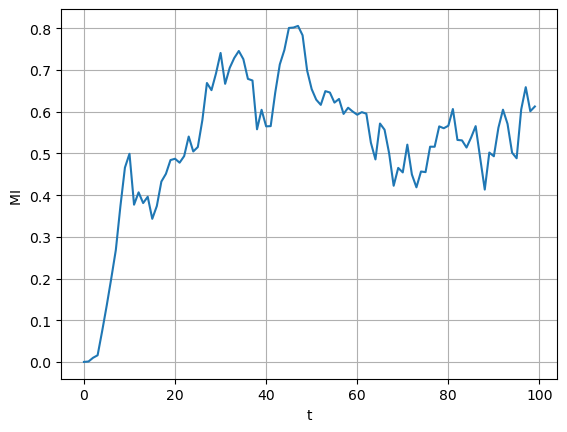

In [345]:
plt.plot(iteration,MI.mean(axis=0))
plt.grid('on')
plt.xlabel('t')
plt.ylabel('MI ')

In [50]:
z=[([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L)/np.log(2) for i in range(gtn.L)]) for dl in range(1,gtn.L//2)]

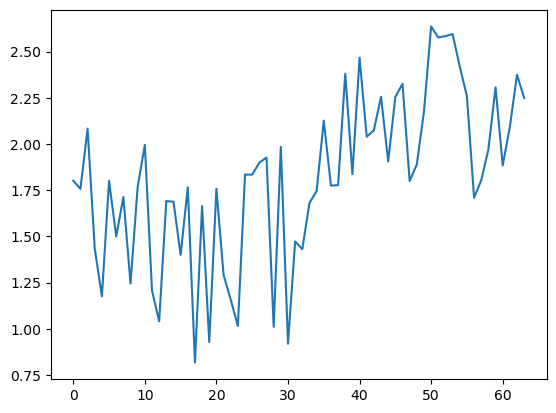

In [51]:
plt.plot(z[10])

Text(0, 0.5, 'EE (log2)')

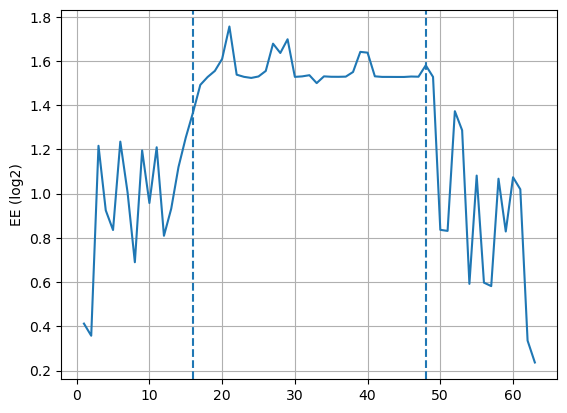

In [271]:
fig,ax=plt.subplots()
ax.plot(range(1,gtn.L),[np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+dl))%gtn.L)/np.log(2) for i in range(1)]) for dl in range(1,gtn.L)])
ax.grid('on')
ax.axvline(x=gtn.L//4,ls='dashed')
ax.axvline(x=gtn.L//4*3,ls='dashed')
ax.set_ylabel('EE (log2)')

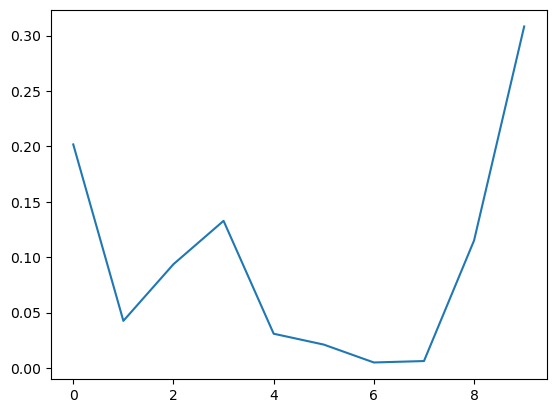

In [135]:
plt.plot(gtn.entanglement_contour(np.arange(10))/np.log(2))

In [139]:
gtn.mutual_information_cross_ratio()/np.log(2)

0.3803550405436396

In [141]:
zz=gtn.C_m_history[-1]

In [142]:
np.round(gtn.C_m_history[-1],2)

array([[ 0.  ,  0.54,  0.65, ..., -0.03, -0.24,  0.11],
       [-0.54,  0.  ,  0.41, ...,  0.01,  0.04,  0.22],
       [-0.65, -0.41,  0.  , ...,  0.01,  0.04,  0.25],
       ...,
       [ 0.03, -0.01, -0.01, ...,  0.  ,  0.73,  0.11],
       [ 0.24, -0.04, -0.04, ..., -0.73,  0.  ,  0.62],
       [-0.11, -0.22, -0.25, ..., -0.11, -0.62,  0.  ]])

In [143]:
np.sum(gtn.entanglement_contour(np.arange(gtn.L)))

1.617875789891762e-10

Text(0.5, 0, 'i')

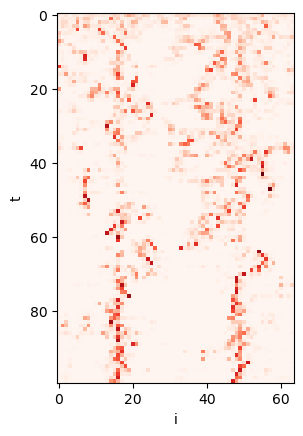

In [261]:
fig,ax=plt.subplots()
# ax.imshow(EC[0],cmap='Reds')
ax.imshow(np.array([ec/nla.norm(ec) for ec in EC[0]]),cmap='Reds')
ax.set_ylabel('t')
ax.set_xlabel('i')

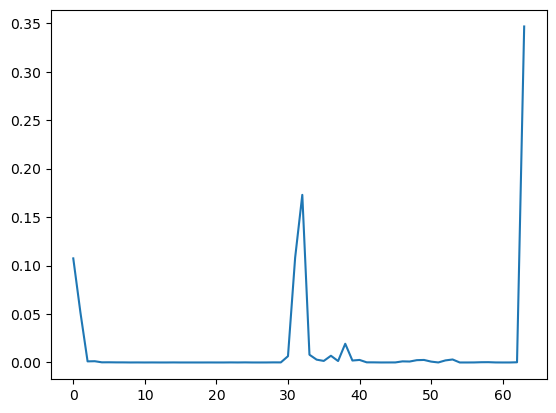

In [144]:
plt.plot(gtn.entanglement_contour(np.arange(gtn.L//2)))

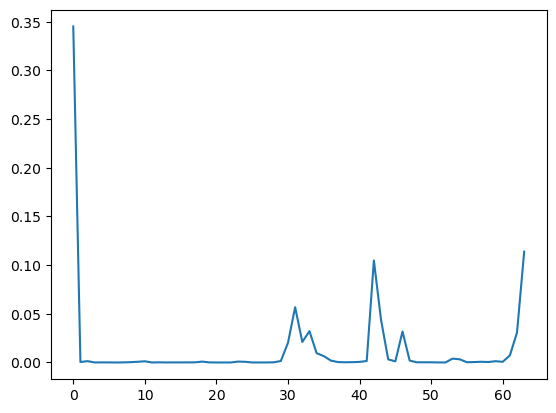

In [145]:
plt.plot(gtn.entanglement_contour(gtn.L//2+np.arange(gtn.L//2)))

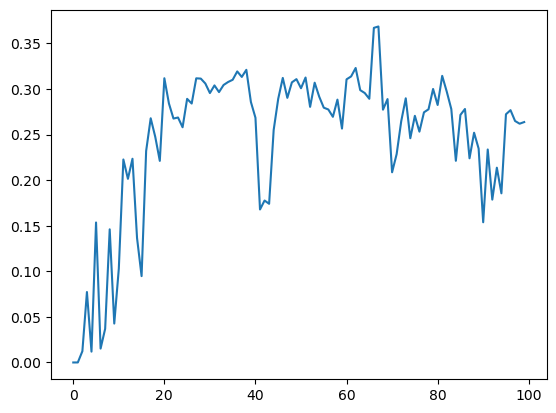

In [8]:
plt.plot(iteration,MI.mean(axis=0))

In [524]:
n2,n3=get_inplane(0, num=10000)

(array([2104.,  872.,  762.,  650.,  625.,  621.,  690.,  750.,  910.,
        2016.]),
 array([-9.99999985e-01, -8.00000051e-01, -6.00000117e-01, -4.00000182e-01,
        -2.00000248e-01, -3.13884356e-07,  1.99999620e-01,  3.99999555e-01,
         5.99999489e-01,  7.99999423e-01,  9.99999357e-01]),
 <BarContainer object of 10 artists>)

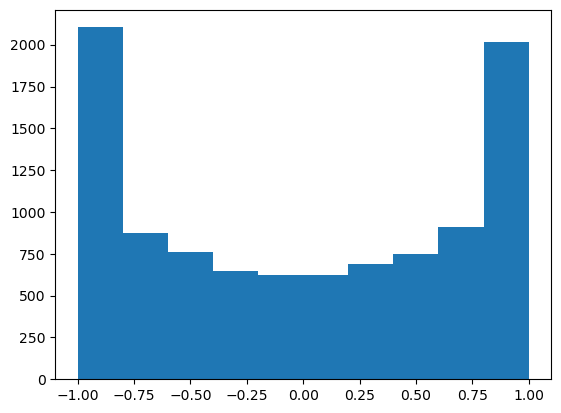

In [525]:
plt.hist(n2)

(array([2064.,  928.,  743.,  703.,  634.,  612.,  667.,  745.,  901.,
        2003.]),
 array([-9.99999863e-01, -7.99999891e-01, -5.99999919e-01, -3.99999947e-01,
        -1.99999975e-01, -2.78171575e-09,  1.99999969e-01,  3.99999941e-01,
         5.99999914e-01,  7.99999886e-01,  9.99999858e-01]),
 <BarContainer object of 10 artists>)

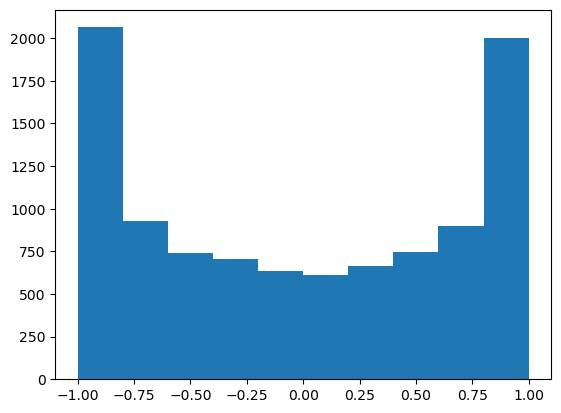

In [519]:
plt.hist(np.sin(np.random.random(size=10000)*np.pi*2))

In [601]:
# L=128
L_list=[32,64,128,256]
# iteration=np.arange(128)
ensemble_size=10
SL2=np.zeros((len(L_list),ensemble_size,))

for L_i,L in enumerate(L_list):
    print(L)
    for ensemble in range(ensemble_size):
        gtn=GTN(L=L,history=True,seed=ensemble)
        for i in range(L):
            gtn.measure_all_Haar(sigma=.3,even=True,theta_list=0,phi_list=0)
            gtn.measure_all_Haar(sigma=.3,even=False,theta_list=np.pi/2,phi_list=np.pi/2)
        SL2[L_i,ensemble]=np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+gtn.L//2))%gtn.L) for i in range(gtn.L)])

32
64
128


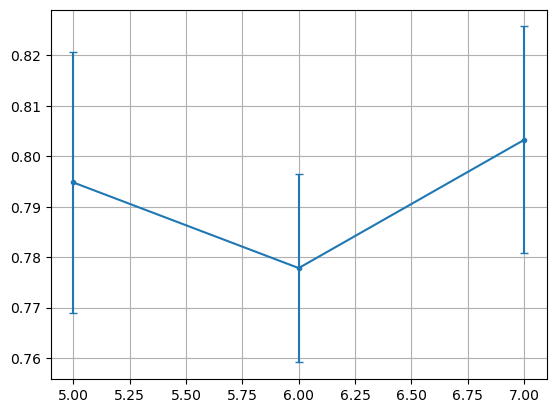

In [ ]:
fig,ax=plt.subplots()
ax.errorbar(np.log2(L_list),SL2.mean(axis=1),SL2.std(axis=1)/np.sqrt(SL2.shape[0]),capsize=3,fmt='.-')
ax.grid('on')

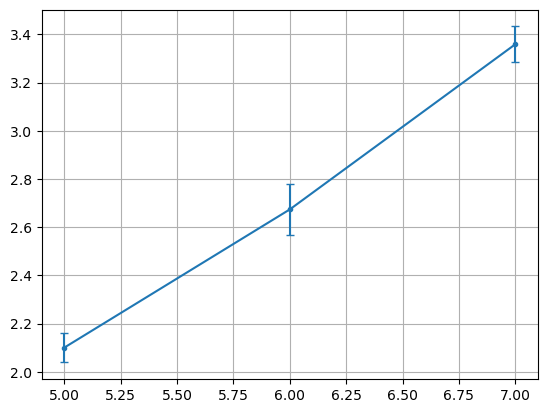

In [ ]:
fig,ax=plt.subplots()
ax.errorbar(np.log2(L_list),SL2.mean(axis=1),SL2.std(axis=1)/np.sqrt(SL2.shape[0]),capsize=3,fmt='.-')
ax.grid('on')

In [590]:
gtn.von_Neumann_entropy_m(np.arange(gtn.L//2))

2.1587535655786243

In [593]:
np.mean([gtn.von_Neumann_entropy_m(np.arange(i,(i+gtn.L//2))%gtn.L) for i in range(gtn.L)])

0.7946802264146469

In [565]:
# zz=get_random(a1=.5,a2=.5,b1=.5,b2=.5,num=10000)
zz=get_Haar(.25, 10000)

(array([269., 420., 470., 514., 512., 591., 580., 576., 603., 583., 545.,
        546., 557., 578., 504., 555., 494., 478., 383., 242.]),
 array([-0.86568839, -0.77920701, -0.69272563, -0.60624426, -0.51976288,
        -0.4332815 , -0.34680012, -0.26031874, -0.17383737, -0.08735599,
        -0.00087461,  0.08560677,  0.17208815,  0.25856952,  0.3450509 ,
         0.43153228,  0.51801366,  0.60449503,  0.69097641,  0.77745779,
         0.86393917]),
 <BarContainer object of 20 artists>)

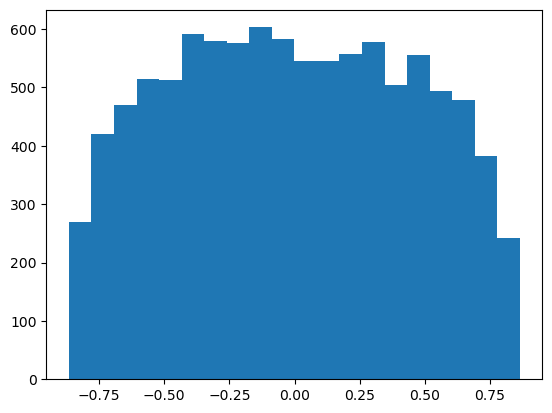

In [568]:
plt.hist(zz[:,2],bins=20)
# plt.hist(n3,bins=20)

In [508]:
np.sqrt(1-0.9**2)

0.4358898943540673

In [22]:
x=np.random.uniform(size=1000)

In [23]:
y=np.sqrt(x)

(array([ 29.,  38.,  45.,  77.,  92., 109., 131., 145., 171., 163.]),
 array([0.04806721, 0.14314844, 0.23822967, 0.3333109 , 0.42839213,
        0.52347336, 0.61855459, 0.71363582, 0.80871705, 0.90379828,
        0.99887951]),
 <BarContainer object of 10 artists>)

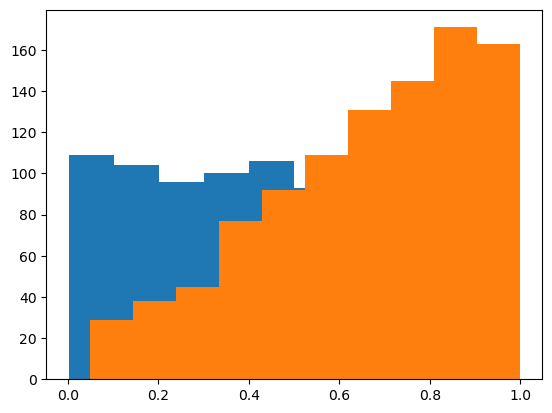

In [28]:
plt.hist(x)
plt.hist(y)

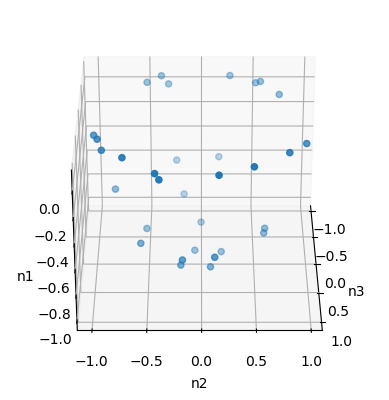

In [107]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
zz=np.array(gtn.n_history[:32])
ax.scatter(zz[:,2],zz[:,1],zz[:,0])
ax.set_xlabel('n3')
ax.set_ylabel('n2')
ax.set_zlabel('n1')
ax.view_init(azim=0)

In [309]:
gtn=GTN(L=128)
for r in range(10):
    for i in range(0,gtn.L,2):
        gtn.measure([1,0,0], [i,(i+1)%(2*gtn.L)])
    for i in range(1,gtn.L,2):
        gtn.measure([0,0,1], [i,(i+1)%(2*gtn.L)])
# gtn.measure_all_forced(b2=1,a2= 1, a1= 1,b1= 1,even=True,n1_z=True)
# mat1,mat2,mat3=gtn.measure(np.array([0,1,0]), [0,1])
# mat1,mat2,mat3=gtn.measure(np.array([-.99999,np.sqrt(1-.99999**2),0]), [0,1])

In [310]:
gtn.mutual_information_cross_ratio()

0.0

In [ ]:
gtn.n_history

In [271]:
mat1

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [272]:
mat2

array([[ 0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [273]:
mat3

array([[ 0.,  1.,  1.,  0.],
       [-1.,  0.,  0.,  1.],
       [-1., -0.,  0.,  0.],
       [-0., -1.,  0.,  0.]])

In [274]:
pd.DataFrame(np.linalg.inv(mat3))

,0,1,2,3
0,-0.0,-0.0,-1.0,-0.0
1,0.0,0.0,0.0,-1.0
2,1.0,0.0,0.0,1.0
3,-0.0,1.0,-1.0,-0.0


In [275]:
gtn.n_history

[array([0, 1, 0])]

In [276]:
gtn.C_m_history

[array([[ 0.,  1.,  0.,  0.],
        [-1.,  0., -0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-0.,  0., -1.,  0.]]),
 array([[ 0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.]])]

In [296]:
L_list=2**np.arange(4,8)
iteration=np.arange(200)
MI=np.zeros((L_list.shape[0],iteration.shape[0]))
for L_i,L in enumerate(L_list):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=0.1,a2= 0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=0.1,a2= 0, a1=.5,b1= 1,even=False,n1_z=False)
        MI[L_i,i]=gtn.mutual_information_cross_ratio()

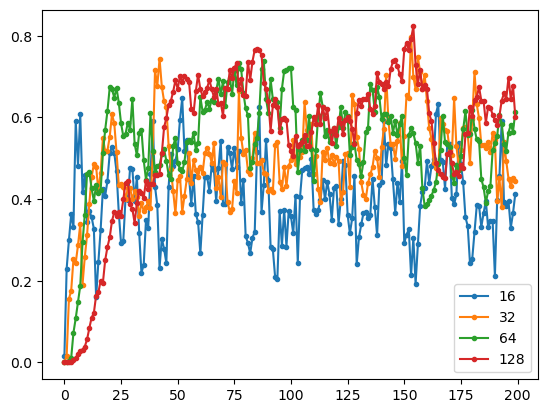

In [298]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

In [299]:
L_list=2**np.arange(4,8)
iteration=np.arange(200)
MI_critical=np.zeros((L_list.shape[0],iteration.shape[0]))
for L_i,L in enumerate(L_list):
    gtn=GTN(L=L)
    for i in iteration:
        gtn.measure_all_forced(b2=1,a2= 0, a1=.5,b1= 1,even=True,n1_z=True)
        gtn.measure_all_forced(b2=1,a2= 0, a1=.5,b1= 1,even=False,n1_z=False)
        MI_critical[L_i,i]=gtn.mutual_information_cross_ratio()

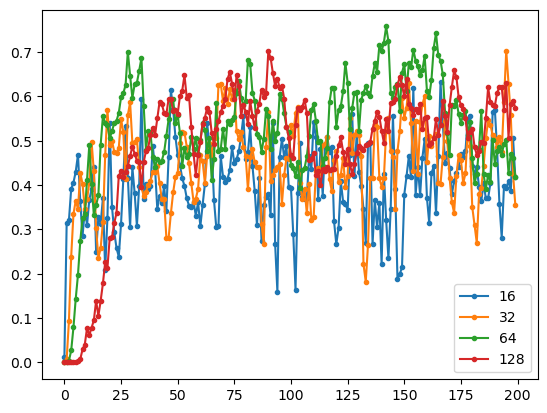

In [300]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI_critical[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI_critical[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

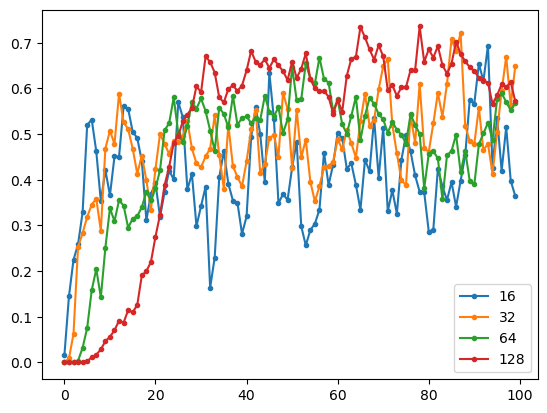

In [192]:
fig,ax=plt.subplots()
# ax.plot(L_list,np.mean(MI_critical[:,-10:],axis=1),'.-')
for i in range(L_list.shape[0]):
    ax.plot(MI_critical[i],'.-',label=str(L_list[i]))
ax.legend()
# ax.set_xscale('log')

In [255]:
gtn.measure(np.array([1,0,0]), [0,1])

In [257]:
gtn.measure(np.array([1,1,0]), [0,1])

In [285]:
# gtn.measure_all_forced(b2=-.9,a2= -.7, a1=.7,b1= .9)
gtn.measure_all_forced(b2=-.9,a2= -.7, a1=.7,b1= .9,even=False)

In [283]:
gtn.n_history

[array([ 0.70708212, -0.6158029 ,  0.34759411]),
 array([ 0.71292935, -0.07927067,  0.69674092]),
 array([-0.73656885,  0.6753321 ,  0.03732137]),
 array([-0.87550474, -0.06941651, -0.47819745])]

In [209]:
np.round(gtn.kraus(gtn.n_history[0]))

array([[-0.,  1., -0., -0.],
       [-1., -0.,  0., -0.],
       [ 0., -0., -0., -1.],
       [ 0.,  0.,  1., -0.]])

In [288]:
gtn.mutual_information_m([0,1],[2,3])/np.log(2)

2.718401573307823

In [ ]:
gtn.C_m_history

In [287]:
np.round(gtn.C_m_history[-1]@gtn.C_m_history[-1]+np.eye(gtn.C_m_history[-1].shape[0]),4)

array([[ 0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0.,  0.],
       [-0.,  0.,  0.,  0., -0., -0., -0., -0.],
       [ 0., -0., -0., -0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0., -0., -0.,  0., -0.,  0.],
       [ 0., -0., -0., -0.,  0., -0.,  0.,  0.],
       [-0., -0.,  0., -0., -0.,  0.,  0.,  0.]])

In [154]:
zz=gtn.get_random(b2=-.8,a2= -.2, a1=.6,b1= .8,n= 100)

In [ ]:
zz

In [156]:
np.linalg.norm(zz,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

(array([646., 675., 635., 655., 646., 684., 672., 722., 665., 636., 689.,
        162.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 511., 678., 641., 683.]),
 array([-7.99993005e-01, -7.46663848e-01, -6.93334691e-01, -6.40005535e-01,
        -5.86676378e-01, -5.33347221e-01, -4.80018065e-01, -4.26688908e-01,
        -3.73359751e-01, -3.20030595e-01, -2.66701438e-01, -2.13372281e-01,
        -1.60043125e-01, -1.06713968e-01, -5.33848111e-02, -5.56544542e-05,
         5.32735022e-02,  1.06602659e-01,  1.59931816e-01,  2.13260972e-01,
         2.66590129e-01,  3.19919286e-01,  3.73248442e-01,  4.26577599e-01,
         4.79906756e-01,  5.33235912e-01,  5.86565069e-01,  6.39894226e-01,
         6.93223383e-01,  7.46552539e-01,  7.99881696e-01]),
 <BarContainer object of 30 artists>)

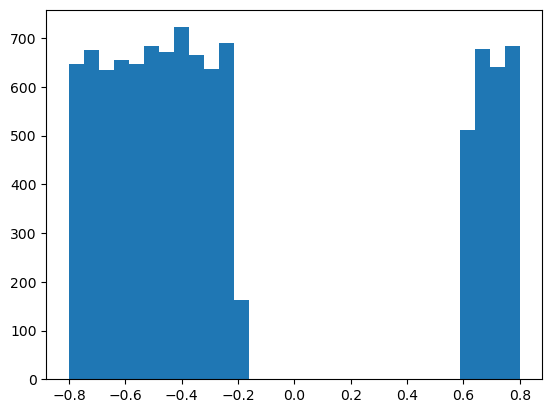

In [124]:
plt.hist(zz,30)

In [97]:
gtn.kraus(np.array([1,0,0]),theta=0)

array([[ 0.,  1.,  0.,  0.],
       [-1.,  0., -0.,  0.],
       [-0.,  0.,  0., -1.],
       [-0., -0.,  1.,  0.]])

In [77]:
gtn.C_m

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0., -0.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [-0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [67]:
gtn.C_m=np.array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [72]:
gtn.C_m_history=[np.array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])]

In [56]:
gtn.measure(0, [0,1])

In [57]:
gtn.i_history

[[0, 1], [0, 1]]

In [73]:
gtn.C_m_history

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])]

In [25]:
gtn.measure(0, [0,1])

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0., -0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0., -0.,  0., -1.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -0.,  0., -0.,  0., -1.,  0.]])

In [19]:
gtn.measure(1, [1,2])

array([[ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

In [60]:
gtn.von_Neumann_entropy_m([0,1])

In [75]:
gtn.mutual_information_m([0,1],[2,3])/np.log(2)

2.0

## Results

In [39]:
import pickle

In [56]:
with open('GTN_a1(0.50,0.50,1)_a2(0.00,0.99,3)_b1(1.00,1.00,1)_b2(1.00,1.00,1)_En10_L64_t64.pickle','rb') as f:
    rs=pickle.load(f)

In [57]:
rs['MI']

array([[[[[5.34930268e-01, 5.12724246e-01, 5.21051890e-01,
           3.78899784e-01, 4.88208458e-01, 3.68155644e-01,
           2.95343834e-01, 5.72998790e-01, 3.87926835e-01,
           4.61489679e-01]]],


        [[[2.94837497e-01, 4.52231408e-01, 4.09681630e-01,
           3.56211882e-01, 3.83134685e-01, 2.44557651e-01,
           2.10717734e-01, 4.00348471e-01, 2.56500704e-01,
           2.60293487e-01]]],


        [[[2.75383378e-03, 1.88000930e-03, 1.12325005e-06,
           3.50104796e-05, 3.58217193e-07, 1.38587909e-08,
           2.65846653e-03, 1.39310617e-01, 1.01578417e-04,
           9.67001293e-04]]]]])

In [58]:
rs['MI'].shape

(1, 3, 1, 1, 10)

In [59]:
rs['MI'].mean(axis=-1)

array([[[[0.45217294]],

        [[0.32685151]],

        [[0.0147708 ]]]])

In [60]:
rs['params']

KeyError: 'params'

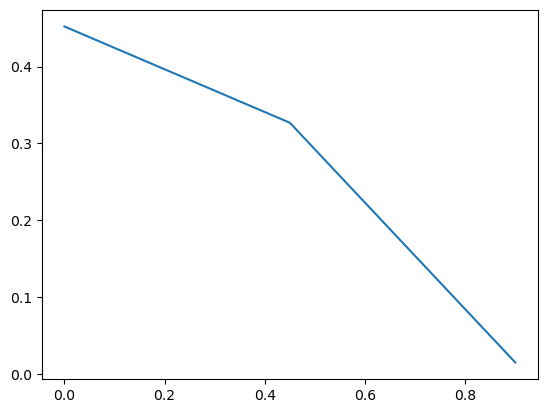

In [61]:
plt.plot(np.linspace(0,0.9,3),np.squeeze(rs['MI'].mean(axis=-1)))